In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.inspection import permutation_importance
import shap

Load data and model

In [2]:
cwd = os.getcwd()
df_lgbm = pd.read_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm.parquet'))
df_xgb = pd.read_parquet(os.path.join(cwd, 'data', 'modelling', 'xgb.parquet'))
df_lgbm.sort_index(inplace=True)
df_xgb.sort_index(inplace=True)
df_X = df_xgb.drop(['goal', 'split', 'match_id', 'wyscout_id', 'statsbomb_id'], axis=1).copy()
df_X2 = df_lgbm.drop(['goal', 'split', 'match_id', 'wyscout_id', 'statsbomb_id'], axis=1).copy()
model = load(os.path.join(cwd, 'models', 'xgb_model.joblib'))
model2 = load(os.path.join(cwd, 'models', 'lgbm_model.joblib'))

Get feature names

In [3]:
features = df_X.columns
features = np.array([f.replace('_', ' ') for f in features])
features2 = df_X2.columns
features2 = np.array([f.replace('_', ' ') for f in features2])

xg predictions. First have to fit to training data

In [4]:
df_xgb['xg'] = model.predict_proba(df_X)[:, 1]
df_lgbm['xg'] = model2.predict_proba(df_X2)[:, 1]

Get a datafrane if the uncalibrated/ calibrated probabilities for each of the three models

In [5]:
models = model.calibrated_classifiers_
estimators = [model.base_estimator for model in models]
probabilities = []
for i in range(3):
    probabilities.append(estimators[i].predict_proba(df_X)[:, 1])
    probabilities.append(models[i].predict_proba(df_X)[:, 1])
df_probabilities = pd.DataFrame(np.vstack(probabilities).T, columns=['uncalibrated0', 'calibrated0',
                                                                     'uncalibrated1', 'calibrated1',
                                                                     'uncalibrated2', 'calibrated2'])
df_probabilities['calibrated'] = model.predict_proba(df_X)[:, 1]
df_probabilities

,uncalibrated0,calibrated0,uncalibrated1,calibrated1,uncalibrated2,calibrated2,calibrated
0,0.078092,0.064042,0.090573,0.089778,0.081945,0.067524,0.073781
1,0.018980,0.017857,0.020845,0.019888,0.016889,0.019859,0.019201
2,0.012755,0.010111,0.014877,0.009804,0.018838,0.019859,0.013258
3,0.026072,0.017857,0.025590,0.025520,0.029832,0.027132,0.023503
4,0.034835,0.034520,0.023430,0.019888,0.033849,0.039002,0.031136
...,...,...,...,...,...,...,...
64501,0.759968,0.642045,0.744963,0.756757,0.776912,0.849133,0.749312
64502,0.033744,0.034520,0.033702,0.033066,0.042425,0.043172,0.036919
64503,0.087328,0.085890,0.097997,0.099042,0.104139,0.108875,0.097935
64504,0.071534,0.064042,0.097015,0.099042,0.103367,0.108875,0.090653


Shap values from shap package.

In [6]:
sample = data=df_X.sample(500).astype(np.float32)
contributions = []
for estimator in estimators:
    explainer = shap.TreeExplainer(estimator, data=sample, model_output='probability')
    shap_values_probability = explainer.shap_values(df_X)
    bias = explainer.expected_value
    df_contributions_probability = pd.DataFrame(shap_values_probability, columns=features)
    df_contributions_probability['bias'] = bias
    contributions.append(df_contributions_probability)

100%|===================| 64287/64506 [02:02<00:00]        

Scale the uncalibrated contributions to sum to the calibrated predicted probability

In [7]:
scaled_contributions = []
for i in range(3):
    scaled = (contributions[i]
              .divide(df_probabilities[f'uncalibrated{i}'], axis=0)
              .multiply(df_probabilities[f'calibrated{i}'], axis=0))
    scaled_contributions.append(scaled)   
df_scaled_contributions = (scaled_contributions[0] + scaled_contributions[1] + scaled_contributions[2])/3.

Remove a few where the scaled contributions don't match the actual xg

In [8]:
df_base = df_xgb[['match_id', 'wyscout_id', 'statsbomb_id', 'xg']]

In [9]:
df_scaled_contributions.reset_index(drop=True, inplace=True)
df_base.reset_index(drop=True, inplace=True)

In [10]:
mask_contributions_not_equal = ((df_scaled_contributions.sum(axis=1) - df_base.xg).abs() > 0.01)
df_scaled_contributions[mask_contributions_not_equal] = np.nan

Return a dataframe with the contirubtions, match and event ids, and the contributions and xg

In [11]:
df_base = df_base.merge(df_scaled_contributions,
                        left_index=True,
                        right_index=True,
                        how='left',
                        validate='1:1')

Save the dataframe

In [12]:
df_base.to_parquet(os.path.join(cwd, 'data', 'modelling', 'xg_shap_xgb.parquet'))

Same process for LightGBM model.

In [20]:
models2 = model2.calibrated_classifiers_
estimators2 = [model2.base_estimator for model2 in models2]
probabilities2 = []
for i in range(3):
    probabilities2.append(estimators2[i].predict_proba(df_X2)[:, 1])
    probabilities2.append(models2[i].predict_proba(df_X2)[:, 1])
df_probabilities2 = pd.DataFrame(np.vstack(probabilities2).T, columns=['uncalibrated0', 'calibrated0',
                                                                     'uncalibrated1', 'calibrated1',
                                                                     'uncalibrated2', 'calibrated2'])
df_probabilities2['calibrated'] = model2.predict_proba(df_X)[:, 1]
df_probabilities2

,uncalibrated0,calibrated0,uncalibrated1,calibrated1,uncalibrated2,calibrated2,calibrated
0,0.061041,0.062291,0.055159,0.059028,0.114096,0.118527,0.079949
1,0.016283,0.024404,0.010298,0.013026,0.012663,0.023504,0.020311
2,0.011210,0.017677,0.006496,0.009479,0.015099,0.026270,0.017808
3,0.011663,0.017677,0.024173,0.026757,0.021094,0.026270,0.023568
4,0.053396,0.055970,0.017824,0.026757,0.039141,0.040943,0.041223
...,...,...,...,...,...,...,...
64501,0.834611,0.800000,0.816485,0.870968,0.760390,0.701031,0.790666
64502,0.050373,0.045588,0.044116,0.056402,0.034312,0.038008,0.046666
64503,0.088149,0.091104,0.127988,0.109864,0.109708,0.108844,0.103270
64504,0.055045,0.056738,0.111904,0.109864,0.090036,0.107722,0.091441


In [21]:
sample2 = data2=df_X2.sample(500).astype(np.float32)
contributions2 = []
for estimator2 in estimators2:
    explainer2 = shap.TreeExplainer(estimator2, data=sample2, model_output='probability')
    shap_values_probability2 = explainer2.shap_values(df_X2)
    bias2 = explainer2.expected_value
    df_contributions_probability2 = pd.DataFrame(shap_values_probability2, columns=features2)
    df_contributions_probability2['bias'] = bias2
    contributions2.append(df_contributions_probability2)

100%|===================| 64469/64506 [16:23<00:00]        

In [22]:
scaled_contributions2 = []
for i in range(3):
    scaled2 = (contributions2[i]
              .divide(df_probabilities2[f'uncalibrated{i}'], axis=0)
              .multiply(df_probabilities2[f'calibrated{i}'], axis=0))
    scaled_contributions2.append(scaled2)   
df_scaled_contributions2 = (scaled_contributions2[0] + scaled_contributions2[1] + scaled_contributions2[2])/3.

In [23]:
df_base2 = df_lgbm[['match_id', 'wyscout_id', 'statsbomb_id', 'xg']]

In [24]:
df_scaled_contributions2.reset_index(drop=True, inplace=True)
df_base2.reset_index(drop=True, inplace=True)

In [25]:
mask_contributions_not_equal2 = ((df_scaled_contributions2.sum(axis=1) - df_base2.xg).abs() > 0.01)
df_scaled_contributions[mask_contributions_not_equal2] = np.nan

In [26]:
df_base2 = df_base.merge(df_scaled_contributions2,
                        left_index=True,
                        right_index=True,
                        how='left',
                        validate='1:1')

In [27]:
df_base2.to_parquet(os.path.join(cwd, 'data', 'modelling', 'xg_shap_lgbm.parquet'))

Use Shap to plot a contribution

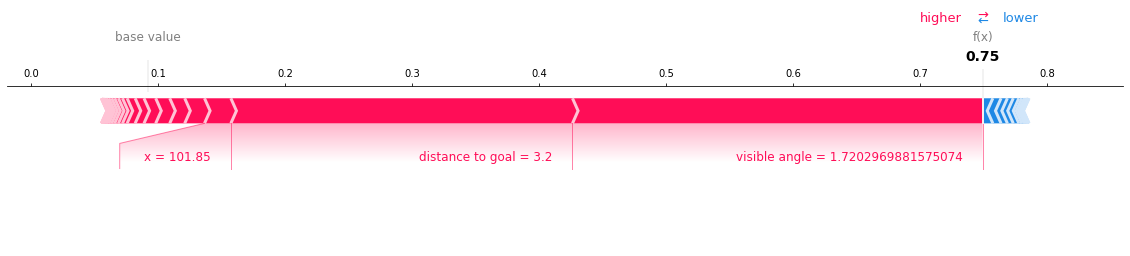

<Figure size 432x288 with 0 Axes>

In [45]:
idx=-5
shap.force_plot(df_scaled_contributions.iloc[idx, -1], 
                df_scaled_contributions.iloc[idx, :-1].values,
                features=df_X.iloc[idx].values,
                feature_names=features, matplotlib=True, show=True)
fig = plt.gcf()
fig.savefig(os.path.join(cwd, 'figures', '08_shap_example.png'), bbox_inches = 'tight', pad_inches = 0.2)

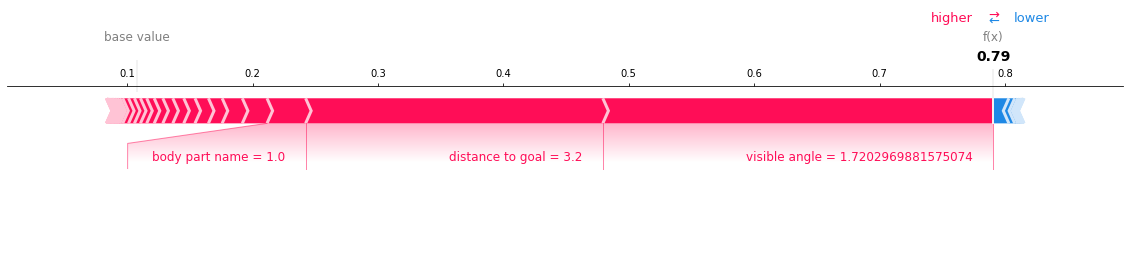

<Figure size 432x288 with 0 Axes>

In [46]:
idx=-5
shap.force_plot(df_scaled_contributions2.iloc[idx, -1], 
                df_scaled_contributions2.iloc[idx, :-1].values,
                features=df_X2.iloc[idx].values,
                feature_names=features, matplotlib=True, show=True)
fig = plt.gcf()